In [ ]:
from datasets import load_dataset

dataset = load_dataset("AzharAli05/Resume-Screening-Dataset")

dataset.save_to_disk("Dataset/Resume_screening_dataset")


In [3]:

import pandas as pd

dataframe1 = pd.read_parquet("Dataset/resume-screening-dataset.parquet")
dataframe1 = dataframe1[['Resume' , 'Decision' , 'Job_Description']]
dataframe1['Decision'] = dataframe1['Decision'].apply(lambda  x : 1 if x.lower() == 'select' else 0)


dataframe2 = pd.read_csv("Dataset/job_applicant_dataset.csv")
dataframe2 = dataframe2[['Resume' , 'Job Description' , 'Best Match']]

dataframe2.rename(columns={'Job Description' : "Job_Description" , "Best Match" : "Decision"} , inplace=True)


df = pd.concat([dataframe1 , dataframe2] , axis=0 , ignore_index=True).reset_index(drop=True)

df.tail()

,Resume,Decision,Job_Description
20169,"Proficient in Biology, Regulatory Compliance, ...",0,A Biomedical Engineer designs and develops med...
20170,"Proficient in Communication, Teamwork, Lesson ...",0,A Teacher shapes the future of students by del...
20171,"Proficient in Medical Terminology, Critical Th...",0,"Diagnose and treat illnesses, prescribe medica..."
20172,"Proficient in Exercise Programming, Motivation...",1,A Fitness Coach is responsible for helping cl...
20173,"Proficient in Content Strategy, Copywriting, C...",0,"As a Content Writer, you will create written m..."


In [5]:
df['Decision'].unique()

array([0, 1])

In [6]:
print("Null values :-\n" , df.isnull().sum())

Null values :-
 Resume             0
Decision           0
Job_Description    0
dtype: int64


In [ ]:
import nltk
nltk.download('all')

In [7]:



import string
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

lemmatizer = WordNetLemmatizer()

punctuations = string.punctuation
translator = str.maketrans('', '', string.punctuation)

def preprocess_text(text :str):
    text = text.lower()    

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove punctuations
    text = text.translate(translator)

    # Tokenize the sentence
    tokenized_words = word_tokenize(text)


    cleaned_words = [lemmatizer.lemmatize(word) for word in tokenized_words if word not in STOPWORDS]


    return ' '.join(cleaned_words)


df[['Resume', 'Job_Description']] = df[['Resume', 'Job_Description']].map(preprocess_text)


df['Decision'] = df['Decision'].apply(lambda x : str(x).lower())

In [8]:
# Remove the most frequent words

from collections import Counter




resume_words = []
job_description_words = []

for resume_sentence , job_description_sentence in zip(df['Resume'] , df['Job_Description']):

    resume_words.extend(word_tokenize(resume_sentence))
    job_description_words.extend(word_tokenize(job_description_sentence))


resume_common_words = Counter(resume_words).most_common(n=10)
job_description_common_words = Counter(job_description_words).most_common(n=10)


def remove_common_words(text, common_words):
    # Tokenize the text and remove common words
    tokenized_words = word_tokenize(text.lower())
    cleaned_words = [word for word in tokenized_words if word not in common_words and word.isalpha()]
    return ' '.join(cleaned_words)


df['Resume'] = df['Resume'].apply(lambda x: remove_common_words(x, resume_common_words))
df['Job_Description'] = df['Job_Description'].apply(lambda x: remove_common_words(x, job_description_common_words))

In [9]:
# These are repeating a lot in data frame 1 

words_to_remove = ["here", "professional", "resume"]

# Create regex pattern: \b(word1|word2|word3)\b
pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'

df['Resume'] = df['Resume'].str.replace(pattern, '', regex=True, case=False)

# Optional: clean up extra spaces
df['Resume'] = df['Resume'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [10]:
cleaned_df=df.copy()

In [11]:
import os

os.makedirs("Dataset/Cleaned_Dataset" , exist_ok=True)

cleaned_df.to_csv("Dataset/Cleaned_Dataset/cleaned_resume_screening.csv" , index=False)

In [18]:
import pandas as pd

cleaned_df = pd.read_csv("Dataset/Cleaned_Dataset/cleaned_resume_screening.csv")

In [19]:
cleaned_df['combined_text'] = cleaned_df['Resume'] + ' [SEP] ' + cleaned_df['Job_Description']


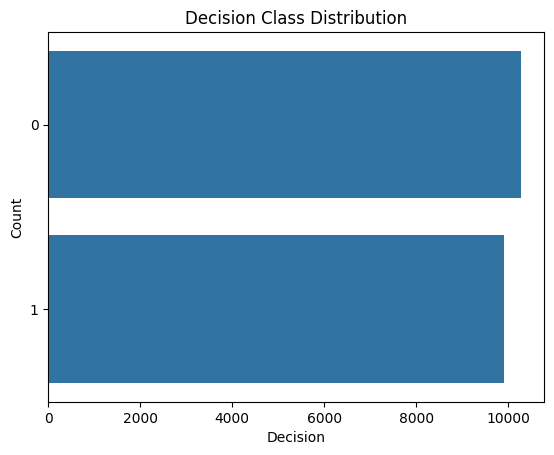

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y='Decision', data=cleaned_df)
plt.title('Decision Class Distribution')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.show()

In [21]:
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np


# Tokenizing the combined text
X_tokenized = [simple_preprocess(text) for text in cleaned_df['combined_text']]
y = cleaned_df['Decision']

# Train Word2Vec model with tokenized text
word2vec_model = Word2Vec(sentences=X_tokenized, vector_size=1000, window=5, min_count=1, workers=4)

# Function to get the average word vector for a document
def get_average_word2vec(tokens_list, model, vector_size=1000):
    vectors = [model.wv[token] for token in tokens_list if token in model.wv]
    if len(vectors) == 0:  # If no words are found in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Convert the entire dataset into word vectors
X_word2vec = np.array([get_average_word2vec(tokens, word2vec_model) for tokens in X_tokenized])

# Split the data into train and test sets after converting to word vectors
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.3, random_state=42)

# Check the shapes of the splits
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(14121, 1000)
(6053, 1000)
(14121,)
(6053,)


In [22]:
cleaned_df['combined_text'].head()[0]

'jason jones jason jones ecommerce specialist contact information email jasonjonesemailcommailtojasonjonesemailcom phone linkedin linkedincominjasonjones summary resultsdriven ecommerce specialist year experience inventory management seo online advertising analytics proven track record increasing online sale improving website traffic optimizing inventory level skilled analyzing complex data set identifying trend making datadriven decision passionate staying uptodate latest ecommerce trend technology experience ecommerce specialist xyz corporation managed inventory level across multiple channel resulting reduction stockouts reduction overstocking developed implemented seo strategy increased website traffic improved search engine ranking created executed online advertising campaign generated increase sale increase conversion rate analyzed website analytics identify trend optimize user experience improve customer engagement collaborated crossfunctional team launch new product line promoti

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(
    max_features=10000,
    strip_accents="unicode", # Strips accents like é -> e
)


X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(
    loss='log_loss',  # Logistic regression (log loss)
    penalty='l2',  # Regularization
    max_iter=1000,  # Max number of iterations
    tol=1e-3,  # Stopping criterion
    random_state=42,
)

sgd_classifier.partial_fit(X_train, y_train, classes=y.unique())  # Initial fit on the training data

y_pred = sgd_classifier.predict(X_test)


sgd_classifier.score(X_test , y_test)

0.5270113993061292

In [27]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
    'max_iter': [1000, 2000],  # Number of iterations
    'learning_rate': ['constant', 'optimal', 'invscaling'],  # Learning rate schedule
    'tol': [1e-4, 1e-3],  # Tolerance for stopping criteria
}

# Initialize SGDClassifier
sgd_classifier = SGDClassifier()

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(sgd_classifier, param_grid, cv=3, n_jobs=-1, verbose=2)

# Perform Grid Search to find the best parameters
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 144 candidates, totalling 432 fits


d:\Recruitment_AI_assitant\Screening-AI\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
288 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Recruitment_AI_assitant\Screening-AI\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Recruitment_AI_assitant\Screening-AI\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\Recruitment_AI_assitant\Screening-AI\.venv

Best parameters found:  {'alpha': 0.001, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.001}
Best cross-validation score: 0.54


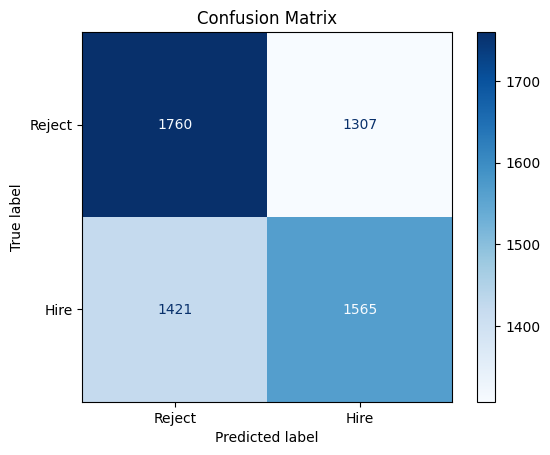

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reject', 'Hire'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [28]:
from sklearn.metrics import accuracy_score , r2_score


print("Accuracy :-" , accuracy_score(y_pred , y_test))
print("R2 score :-" , r2_score(y_test , y_pred))



Accuracy :- 0.5493143895588964
R2 score :- -0.8030653210253433


ROC-AUC Score: 0.5785


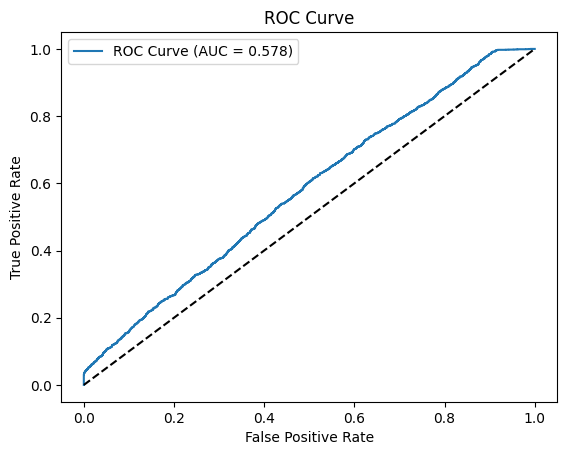

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# For binary classification
y_prob = sgd_classifier.predict_proba(X_test)[:, 1]  # Probability of "Hire"
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()


rfc.fit(X_train , y_train)


rfc.score(X_test , y_test)


In [26]:

import pickle

# -------------------------------

model_data = {
    'vectorizer': vectorizer,
    'classifier': sgd_classifier
}

with open('resume_screening_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model and vectorizer saved to 'resume_screening_model.pkl'")

# -------------------------------
# 4. UNPICKLE (LOAD) AND INFERENCE
# -------------------------------
# Simulate loading in a new session
with open('resume_screening_model.pkl', 'rb') as f:
    loaded = pickle.load(f)

vectorizer = loaded['vectorizer']
classifier = loaded['classifier']

print("Model and vectorizer loaded successfully!")



Model and vectorizer saved to 'resume_screening_model.pkl'
Model and vectorizer loaded successfully!


In [27]:
def predict_hiring_decision(resume_text, job_description):
    # Combine
    combined_text = resume_text + " " + job_description
    combined_text = combined_text.strip()

    # Vectorize
    text_vector = vectorizer.transform([combined_text])

    # Predict
    prediction = classifier.predict(text_vector)[0]
    probability = classifier.predict_proba(text_vector)[0]

    decision = "Hire" if prediction == 1 else "Reject"
    prob_hire = probability[1] if prediction == 1 else probability[0]

    return {
        'Decision': decision,
        'Probability (Hire)': round(probability[1], 4),
        'Confidence': round(max(probability), 4)
    }

sample_idx = 0
sample_resume = df['Resume'].iloc[X_test.index[sample_idx]]
sample_job = df['Job_Description'].iloc[X_test.index[sample_idx]]
true_label = y_test.iloc[sample_idx]

print("\n" + "="*50)
print("INFERENCE EXAMPLE")
print("="*50)
print(f"True Label: {true_label} ({'Hire' if true_label == 1 else 'Reject'})")
print(f"Resume snippet: {sample_resume[:100]}...")
print(f"Job Desc snippet: {sample_job[:100]}...")

result = predict_hiring_decision(sample_resume, sample_job)
print("\nModel Prediction:")
for k, v in result.items():
    print(f"  {k}: {v}")


INFERENCE EXAMPLE
True Label: 1 (Hire)
Resume snippet: proficient injury prevention anatomy goal setting client motivation nutrition seniorlevel experience...
Job Desc snippet: personal trainer will design personalized fitness program help client achieve physical health goal r...

Model Prediction:
  Decision: Reject
  Probability (Hire): 0.4554
  Confidence: 0.5446


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the pre-trained model from Sentence-Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate cosine similarity and classify the resume
def classify_resume(resume_text, job_desc_text):
    # Get sentence embeddings for both resume and job description
    resume_embedding = model.encode(resume_text)
    job_desc_embedding = model.encode(job_desc_text)
    
    # Calculate cosine similarity
    similarity = cosine_similarity([resume_embedding], [job_desc_embedding])[0][0]
    
    # Print similarity and classify the resume
    print(f"Cosine Similarity: {similarity * 100:.2f}%")
    
    # If similarity is greater than 80%, classify as good match
    return similarity

# Example usage:
resume_text_matching = """
    Experienced software engineer with a passion for building scalable systems and solving complex problems.
    Proficient in Python, Java, and cloud technologies like AWS.
    Strong background in algorithms, data structures, and software development methodologies.
"""
resume_text_slightly_matching = """
Experienced software engineer with a strong background in designing and developing software solutions. Proficient in programming languages like Python and Java. Skilled in problem-solving, algorithms, and data structures. I have worked on several projects involving web development and mobile app development. Familiar with Git for version control and experienced in working in agile teams. Looking to apply my technical skills in a new role.
"""

resume_text_drastically_matching = """
Highly skilled artist with a passion for digital painting and illustration. Experienced in Adobe Photoshop, Procreate, and other graphic design tools. Strong portfolio showcasing a variety of digital artwork, including character design and concept art. Avid gamer with a deep interest in fantasy art styles and storytelling through visual media. Looking to transition into a full-time role as a concept artist.
"""


job_desc_text = """
    We are looking for a software engineer with experience in cloud technologies and strong problem-solving skills.
    Proficiency in Python and Java is required, along with knowledge of AWS.
"""

# Classify the resume against the job description
result_matching = classify_resume(resume_text_matching, job_desc_text)
result_slightly_matching = classify_resume(resume_text_slightly_matching, job_desc_text)
result_drastically_matching = classify_resume(resume_text_drastically_matching, job_desc_text)

print(f"Similarity for result_matching :-" , result_matching)
print(f"Similarity for result_slightly_matching :-" , result_slightly_matching)
print(f"Similarity for result_drastically_matching :-" , result_drastically_matching)


d:\Recruitment_AI_assitant\Screening-AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Recruitment_AI_assitant\Screening-AI\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adm

Cosine Similarity: 80.00%
Good Match for the Job
